In [51]:
import numpy as np
import EFIE as solve
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

frequency = 1e6 * 146
omega, wavelength = 2 * np.pi * frequency, light_speed / frequency
incident_field, radius = 10, 3.175e-3
delta_r = wavelength / 5e2

class yagi:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

structure_type = 'yagi-uda'
pos = np.array([[0.0, 0.0, 0.0]])
angle = np.array([[0.0, 0.0]])
lengths = np.array([wavelength/2])
source_position = np.array([[0.0, 0.0, 0.0, incident_field]])
radii = np.array([radius])
test = yagi(pos, angle, lengths, source_position, radii)

In [ ]:
from tqdm import tqdm
import time

dr = wavelength / np.linspace(100, 2000, 20)
I_pulse, I_triangle, E_pulse, E_triangle = np.zeros(len(dr), dtype=object), np.zeros(len(dr), dtype=object), np.zeros(len(dr), dtype=object), np.zeros(len(dr), dtype=object)
R_pulse, R_triangle = np.zeros(len(dr), dtype=object), np.zeros(len(dr), dtype=object)

time_cur_pulse, time_cur_triangle = [], []
time_e_pulse, time_e_triangle = [], []

for i in tqdm(range(len(dr))) :
    
    start = time.time()
    I_pulse[i], R_pulse[i] = solve.calc_current_amplitudes(structure_type=structure_type, basis_functions='pulse', antenna=test, frequency=frequency, delta_r=dr[i])
    time_cur_pulse.append(time.time() - start)
    
    start = time.time()
    E_pulse[i], angles = solve.calc_field_pattern(phi=0, theta=0, basis_functions='pulse', current=I_pulse[i], R=R_pulse[i], delta_r=dr[i], frequency=frequency)
    time_e_pulse.append(time.time() - start)
    
    start = time.time()
    I_triangle[i], R_triangle[i] = solve.calc_current_amplitudes(structure_type=structure_type, basis_functions='triangle', antenna=test, frequency=frequency, delta_r=dr[i])
    time_cur_triangle.append(time.time() - start)
    
    start = time.time()
    E_triangle[i], angles = solve.calc_field_pattern(phi=0, theta=0, basis_functions='pulse', current=I_triangle[i], R=R_triangle[i], delta_r=dr[i], frequency=frequency)
    time_e_triangle.append(time.time() - start)
    
time_cur_pulse, time_cur_triangle = np.array(time_cur_pulse), np.array(time_cur_triangle)
time_e_pulse, time_e_triangle = np.array(time_e_pulse), np.array(time_e_triangle)

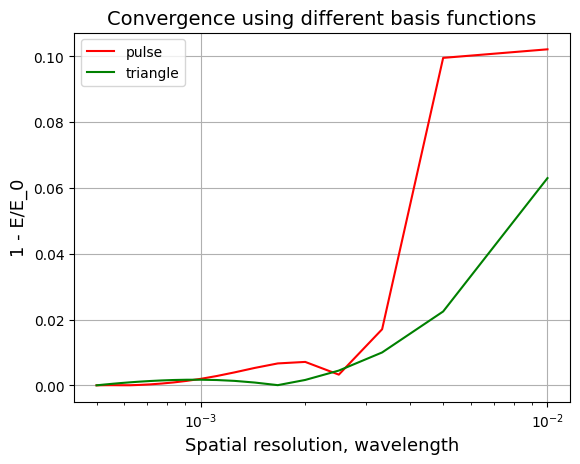

In [114]:
import matplotlib.pyplot as plt
E_max_pulse, E_max_triangle = np.zeros(len(E_pulse)), np.zeros(len(E_pulse))
for i in range(len(E_pulse)):
    E_max_pulse[i] = np.abs(1 - np.max(E_pulse[i])/np.max(E_pulse[-1]))
    E_max_triangle[i] = np.abs(1 - np.max(E_triangle[i])/np.max(E_triangle[-1]))
plt.plot(dr / wavelength, E_max_pulse, color = 'red', label = 'pulse')
plt.plot(dr / wavelength, E_max_triangle, color = 'green', label = 'triangle')
plt.xlabel("Spatial resolution, wavelength", size = 13)
plt.ylabel("1 - E/E_0", size = 13)
plt.title("Convergence using different basis functions", size = 14)
plt.xscale('log')
plt.grid(True)
plt.legend()